这里说频率是指一个机场航班出现的频率

## 加载数据

数据已经预处理过了

In [17]:
import pandas as pd

# 加载数据
data = pd.read_csv('../result/pre_2023-2025_with_comp_train.csv', dtype={'flt_no': str})

# 查看前几行数据，确保加载成功
# 显示前两行数据以确保正确加载
print(data.shape)
print(data.head(5))
print(data.tail(5))

(2060073, 20)
   flt_no    cap aircraft  legs  leg_no  duration  pax       a       b  \
0  3c6705  110.0      195     1       1      1.30   97  a9f275  24cc4b   
1  6a67d9  110.0      195     1       1      1.25   67  d56796  24cc4b   
2  de569b   93.0      190     3       3      4.75   22  d56796  ec1b13   
3  284078  162.0      320     1       1      1.83   55  e3d141  d618e3   
4  f8765b  167.0      320     1       1      3.98  166  9550bc  2e1ea1   

        c   unit_price  competitor_price  year  month  day  weekday  hour  \
0  7f9c2b   470.474227        -94.900773  2023      1    1        6    14   
1  7f9c2b   454.925373       -123.872095  2023      1    1        6    22   
2  dcf90a  1177.818182        977.818182  2023      1    1        6    18   
3  7f9c2b   669.090909          0.000000  2023      1    1        6    12   
4  7f9c2b  1794.783133       1564.978621  2023      1    1        6    13   

   minute from   to  
0      35  a9f  c4b  
1      40  d56  c4b  
2       0  d

In [18]:
# 检查标准化后的统计信息
print("\n标准化后的统计信息：")
print(data['pax'].describe())


标准化后的统计信息：
count    2.060073e+06
mean     1.132931e+02
std      5.341934e+01
min      2.000000e+01
25%      7.000000e+01
50%      1.160000e+02
75%      1.530000e+02
max      3.110000e+02
Name: pax, dtype: float64


## 编码分类变量

### 新增城市标签

In [19]:
import json
# 加载字典
with open('../result/encoder/city_labels_航班频率加权图标签.json', 'r') as file:
    city_labels_loaded = json.load(file)

print("加载的字典：", city_labels_loaded)

加载的字典： {'000': 2, '13f': 1, '8e3': 1, 'a18': 1, 'eda': 2, '01a': 2, 'b5a': 1, 'ea1': 1, '03f': 2, '1be': 1, '3bc': 1, '578': 1, '5df': 1, '5fb': 1, '760': 1, '792': 1, '7ff': 1, '90a': 1, '974': 1, 'bbb': 1, 'cb5': 1, 'ffe': 1, '059': 2, '022': 1, '077': 1, '0d7': 1, '0dd': 1, '1a3': 1, '1e9': 1, '1ed': 1, '25c': 1, '311': 1, '354': 1, '451': 1, '510': 1, '5d7': 2, '63a': 1, '666': 0, '6e3': 0, '7f1': 1, '812': 1, '8a1': 1, '9d4': 2, '9e9': 1, 'b3a': 1, 'bff': 1, 'c24': 1, 'c3a': 1, 'c4c': 1, 'c98': 1, 'c9f': 1, 'cb7': 1, 'd7c': 1, 'e76': 1, 'e9c': 1, 'efb': 1, '05c': 2, '141': 1, '157': 1, '709': 1, '8ac': 0, '97f': 1, '988': 1, 'a2f': 1, 'b09': 1, 'c14': 1, 'c4b': 0, 'e5b': 1, 'ec2': 1, '074': 2, '4d0': 1, '695': 1, 'c2c': 1, 'fa9': 1, '08c': 2, '08f': 2, '3c5': 1, '5e8': 1, 'a72': 1, 'd54': 1, 'ff1': 1, '0ac': 2, '0c8': 2, '0ca': 0, 'e09': 0, '0d1': 2, '13e': 1, '1ee': 1, '43e': 1, '0db': 2, '919': 1, 'd08': 1, '0ff': 2, '11b': 0, '123': 2, '5de': 1, '8eb': 1, '124': 2, '130': 2, '1

In [20]:
# 使用 map 对 'a', 'b', 'c', 'from', 'to' 列进行标签化，新增对应的标签列
data['a_label'] = data['a'].map(city_labels_loaded)
data['b_label'] = data['b'].map(city_labels_loaded)
data['c_label'] = data['c'].map(city_labels_loaded)
data['from_label'] = data['from'].map(city_labels_loaded)
data['to_label'] = data['to'].map(city_labels_loaded)

### 新增城市二维嵌入

In [21]:
import json

# 加载字典
with open('../result/encoder/城市嵌入编码_航班频率加权图.json', 'r') as file:
    city_embeddings = json.load(file)

print("加载的字典：", city_embeddings)


加载的字典： {'000': [-1.3355571031570435, -0.7252184152603149], '13f': [0.7116603255271912, -0.38071975111961365], '8e3': [0.6560439467430115, -0.48669493198394775], 'a18': [0.2972618341445923, -0.32849031686782837], 'eda': [-0.3947368860244751, -1.0661070346832275], '01a': [-1.0750128030776978, -0.22083736956119537], 'b5a': [0.8525970578193665, -0.6555958390235901], 'ea1': [0.22486557066440582, 0.1256379634141922], '03f': [-0.5686646699905396, -0.8201126456260681], '1be': [0.9253679513931274, -0.583831250667572], '3bc': [1.186996579170227, -0.8084284067153931], '578': [1.038602352142334, -0.6717441082000732], '5df': [0.9066036939620972, -0.8123182654380798], '5fb': [0.9960507154464722, -0.22026796638965607], '760': [1.0199142694473267, -0.6170554161071777], '792': [0.242161363363266, -0.4239804744720459], '7ff': [0.9492039084434509, -0.339489221572876], '90a': [0.010870625264942646, -0.008459429256618023], '974': [1.2856382131576538, -0.6693836450576782], 'bbb': [0.688012421131134, -0.6741

In [22]:
import pandas as pd
import numpy as np

# 将 city_embeddings 转换为 DataFrame
embedding_df = pd.DataFrame.from_dict(city_embeddings, orient='index', columns=['embedding_1', 'embedding_2'])
embedding_df.index.name = 'city'

# 用 'a', 'b', 'c', 'from', 'to' 字段与 embedding_df 合并
data = data.merge(embedding_df, left_on='a', right_index=True, how='left')
data.rename(columns={'embedding_1': 'a_embedding_1', 'embedding_2': 'a_embedding_2'}, inplace=True)

data = data.merge(embedding_df, left_on='b', right_index=True, how='left')
data.rename(columns={'embedding_1': 'b_embedding_1', 'embedding_2': 'b_embedding_2'}, inplace=True)

data = data.merge(embedding_df, left_on='c', right_index=True, how='left')
data.rename(columns={'embedding_1': 'c_embedding_1', 'embedding_2': 'c_embedding_2'}, inplace=True)

data = data.merge(embedding_df, left_on='from', right_index=True, how='left')
data.rename(columns={'embedding_1': 'from_embedding_1', 'embedding_2': 'from_embedding_2'}, inplace=True)

data = data.merge(embedding_df, left_on='to', right_index=True, how='left')
data.rename(columns={'embedding_1': 'to_embedding_1', 'embedding_2': 'to_embedding_2'}, inplace=True)

# 查看添加的新列
print(data[['a_embedding_1', 'a_embedding_2', 'b_embedding_1', 'b_embedding_2', 'c_embedding_1', 'c_embedding_2', 'from_embedding_1', 'from_embedding_2', 'to_embedding_1', 'to_embedding_2']])


         a_embedding_1  a_embedding_2  b_embedding_1  b_embedding_2  \
0                  NaN            NaN            NaN            NaN   
1                  NaN            NaN            NaN            NaN   
2                  NaN            NaN            NaN            NaN   
3                  NaN            NaN            NaN            NaN   
4                  NaN            NaN            NaN            NaN   
...                ...            ...            ...            ...   
2060068            NaN            NaN            NaN            NaN   
2060069            NaN            NaN            NaN            NaN   
2060070            NaN            NaN            NaN            NaN   
2060071            NaN            NaN            NaN            NaN   
2060072            NaN            NaN            NaN            NaN   

         c_embedding_1  c_embedding_2  from_embedding_1  from_embedding_2  \
0                  NaN            NaN         -1.308495          1.850

### 频率编码

使用 json 保存和加载 city_map

In [23]:
# 加载city_map
with open('../result/encoder/city_map_频率编码.json', 'r') as f:
    city_map = json.load(f)

# 使用 city_map 替换指定列的值
columns_to_replace = ['a', 'b', 'c', 'from', 'to']

# 遍历指定列并直接用 map 映射
for col in columns_to_replace:
    data[col] = data[col].map(city_map)


print(data)

         flt_no    cap aircraft  legs  leg_no  duration  pax   a   b   c  \
0        3c6705  110.0      195     1       1      1.30   97 NaN NaN NaN   
1        6a67d9  110.0      195     1       1      1.25   67 NaN NaN NaN   
2        de569b   93.0      190     3       3      4.75   22 NaN NaN NaN   
3        284078  162.0      320     1       1      1.83   55 NaN NaN NaN   
4        f8765b  167.0      320     1       1      3.98  166 NaN NaN NaN   
...         ...    ...      ...   ...     ...       ...  ...  ..  ..  ..   
2060068  2f5ac7  161.0      738     3       2      2.58  128 NaN NaN NaN   
2060069  8b52d8  161.0      738     1       1      2.60  152 NaN NaN NaN   
2060070  cac556  161.0      738     1       1      1.77  149 NaN NaN NaN   
2060071  0bd968  188.0      7MZ     1       1      2.40  144 NaN NaN NaN   
2060072  2befc2  161.0      738     1       1      2.48  142 NaN NaN NaN   

          unit_price  competitor_price  year  month  day  weekday  hour  \
0         47

### 'flt_no', 'bd_type', 'aircraft'编码

In [24]:
import joblib
from sklearn.preprocessing import LabelEncoder
import os

# 定义需要编码的分类特征
# categorical_columns = ['flt_no', 'bd_type', 'aircraft']
categorical_columns = ['flt_no', 'aircraft']

# 从保存的文件中加载编码器并应用到data
for col in categorical_columns:
    # 加载编码器
    encoder_path = os.path.join('../result/encoder/', f"{col}_encoder_all.pkl")
    le = joblib.load(encoder_path)
    
    try:
        # 对data进行转换
        data[col] = le.transform(data[col])
        print(f"{col}列编码完成")
    except ValueError as e:
        # 如果遇到新的类别，打印错误信息
        print(f"{col}列编码出错: {str(e)}")
        # 找出新的类别
        new_categories = set(data[col]) - set(le.classes_)
        print(f"{col}列中的新类别: {new_categories}")

# 查看编码后的结果
print("\n编码后的前几行数据：")
print(data[categorical_columns].head())

flt_no列编码完成
aircraft列编码完成

编码后的前几行数据：
aircraft列编码完成

编码后的前几行数据：
   flt_no  aircraft
0    1104         2
1    1872         2
2    3916         0
3     721         9
4    4356         9
   flt_no  aircraft
0    1104         2
1    1872         2
2    3916         0
3     721         9
4    4356         9


## 特征和目标分离
我们要预测的是pax字段，其他字段作为特征。

In [25]:
# 特征列
# X = data[['flt_no', 'bd_type', 'cap', 'aircraft',  'leg_no', 'duration', 'a', 'b', 'c', 'year', 'month', 'day', 'weekday','holiday', 'hour', 'minute', 'second', 'from', 'to','unit_price']]
# X = data[['flt_no', 'bd_type', 'cap', 'aircraft', 'legs', 'leg_no', 'duration', 'a', 'b', 'c', 'year', 'month', 'day', 'weekday','hour', 'minute', 'second', 'from', 'to','unit_price']]
# X = data[['flt_no', 'bd_type', 'cap', 'aircraft', 'legs', 'leg_no', 'duration', 'a', 'b', 'c', 'year', 'month', 'day', 'weekday','hour', 'minute', 'second', 'from', 'to','unit_price','a_label' ,'b_label' ,'c_label' ,'from_label' ,'to_label']]

# 有abc，有标签，有嵌入
# X = data[['flt_no', 'bd_type', 'cap', 'aircraft', 'legs', 'leg_no', 'duration', 'a', 'b', 'c', 'year', 'month', 'day', 'weekday','hour', 'minute', 'second', 'from', 'to','unit_price','a_label' ,'b_label' ,'c_label' ,'from_label' ,'to_label','a_embedding_1' , 'a_embedding_2' , 'b_embedding_1','b_embedding_2' , 'c_embedding_1' , 'c_embedding_2' , 'from_embedding_1','from_embedding_2' , 'to_embedding_1' , 'to_embedding_2']]
# X = data[['flt_no', 'cap', 'aircraft', 'legs', 'leg_no', 'duration', 'a', 'b', 'c', 'year', 'month', 'day', 'weekday','hour', 'minute', 'from', 'to','unit_price','a_label' ,'b_label' ,'c_label' ,'from_label' ,'to_label','a_embedding_1' , 'a_embedding_2' , 'b_embedding_1','b_embedding_2' , 'c_embedding_1' , 'c_embedding_2' , 'from_embedding_1','from_embedding_2' , 'to_embedding_1' , 'to_embedding_2']]
X = data[['flt_no', 'cap', 'aircraft', 'legs', 'leg_no', 'duration', 'a', 'b', 'c', 'year', 'month', 'day', 'weekday','hour', 'minute', 'from', 'to','unit_price','competitor_price','a_label' ,'b_label' ,'c_label' ,'from_label' ,'to_label','a_embedding_1' , 'a_embedding_2' , 'b_embedding_1','b_embedding_2' , 'c_embedding_1' , 'c_embedding_2' , 'from_embedding_1','from_embedding_2' , 'to_embedding_1' , 'to_embedding_2']]

# 删除了abc，但有标签，有嵌入
# X = data[['flt_no', 'bd_type', 'cap', 'aircraft', 'legs', 'leg_no', 'duration', 'year', 'month', 'day', 'weekday','hour', 'minute', 'second', 'unit_price','a_label' ,'b_label' ,'c_label' ,'from_label' ,'to_label','a_embedding_1' , 'a_embedding_2' , 'b_embedding_1','b_embedding_2' , 'c_embedding_1' , 'c_embedding_2' , 'from_embedding_1','from_embedding_2' , 'to_embedding_1' , 'to_embedding_2']]

# 目标列
y = data['pax']

### 对x进行标准化

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib

# 假设你的特征数据是 DataFrame X
# X = pd.read_csv("your_data.csv")

# 1️⃣ 找出无 NaN 的列
valid_cols = [col for col in X.columns if not X[col].isnull().any()]
nan_cols = [col for col in X.columns if X[col].isnull().any()]

print(f"🧩 可标准化列数: {len(valid_cols)}")
print(f"🚫 含 NaN 列数: {len(nan_cols)}")

# 2️⃣ 创建一个副本，保证不修改原数据
X_scaled = X.copy()

# 3️⃣ 对无 NaN 列进行标准化（保持列顺序）
scaler = StandardScaler()
X_scaled_valid = pd.DataFrame(
    scaler.fit_transform(X[valid_cols]),
    columns=valid_cols,
    index=X.index
)

# 4️⃣ 将标准化后的列替换回原表（顺序保持不变）
for col in valid_cols:
    X_scaled[col] = X_scaled_valid[col]

# 5️⃣ 查看结果
pd.set_option('display.max_columns', None)
print("\n✅ 标准化后的前1行数据：")
print(X_scaled.head(1))

# 6️⃣ 保存 scaler
joblib.dump(scaler, '../result/encoder/standard_scaler_x.pkl')
print("\n💾 x的标准化器已保存为 standard_scaler_x.pkl")

# 7️⃣ 输出提示
if nan_cols:
    print("\n⚠️ 以下列未参与标准化（含 NaN 值，保持原样）：")
    print(nan_cols)


🧩 可标准化列数: 21
🚫 含 NaN 列数: 13

✅ 标准化后的前1行数据：
     flt_no       cap  aircraft      legs    leg_no  duration   a   b   c  \
0 -0.843377 -1.518595 -1.369381 -1.046281 -0.624097       1.3 NaN NaN NaN   

       year     month       day   weekday      hour    minute      from  \
0 -0.972083 -1.306395 -1.684848  1.480982  0.063558  0.481137 -1.292931   

         to  unit_price  competitor_price  a_label  b_label  c_label  \
0  0.139294   -0.583246         -0.465818      NaN      NaN      NaN   

   from_label  to_label  a_embedding_1  a_embedding_2  b_embedding_1  \
0    -2.82258 -2.813335            NaN            NaN            NaN   

   b_embedding_2  c_embedding_1  c_embedding_2  from_embedding_1  \
0            NaN            NaN            NaN         -1.593931   

   from_embedding_2  to_embedding_1  to_embedding_2  
0          3.200172       -1.424629        3.099522  

💾 x的标准化器已保存为 standard_scaler_x.pkl

⚠️ 以下列未参与标准化（含 NaN 值，保持原样）：
['duration', 'a', 'b', 'c', 'a_label', 'b_label', '

### 对y进行标准化

In [27]:
# 对目标列 y 进行标准化
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # 将 y 转换为 2D 数组进行标准化

# 转换回 DataFrame 格式
y_scaled = pd.DataFrame(y_scaled, columns=['pax_scaled'])

# 查看标准化后的 y
print(y_scaled.head())

# 保存 y 的 scaler
joblib.dump(scaler_y, '../result/encoder/standard_scaler_y.pkl')
print("y的标准化器已保存为 standard_scaler_y.pkl")

   pax_scaled
0   -0.305004
1   -0.866598
2   -1.708990
3   -1.091236
4    0.986663
y的标准化器已保存为 standard_scaler_y.pkl


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## 训练XGBoost模型

In [28]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# 自定义 SMAPE 函数
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    return np.mean(diff / denominator) * 100

# 自定义评估函数
def smape_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    smape_value = smape(y_true, y_pred)
    return 'SMAPE', smape_value

# 数据划分
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 输出数据集大小
print(f'训练集大小: {X_train.shape[0]}')
print(f'验证集大小: {X_val.shape[0]}')
print(f'测试集大小: {X_test.shape[0]}')

# 转换为 DMatrix 格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# 设置参数
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 10,#10效果最好
    'subsample': 0.8,#0.8效果最好
    'colsample_bytree':1,
    'alpha': 1,
    "lambda":1
}

# 设置评估集
evals = [(dtrain, 'train'), (dval, 'validation')]

# 训练模型，使用自定义评估指标
model = xgb.train(
    params,
    dtrain,
    num_boost_round=750,
    evals=evals,
    early_stopping_rounds=10,
    custom_metric=smape_eval,  # 使用 custom_metric 参数
    verbose_eval=10 #隔多少轮显示一次
)

# 预测测试集
y_pred = model.predict(dtest)

# # 测试集 SMAPE 评估
# test_smape = smape(y_test, y_pred)
# print(f'SMAPE on Test Set: {test_smape:.2f}%')

# # 测试集 MSE 评估
# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error on Test Set: {mse}')

训练集大小: 1648058
验证集大小: 206007
测试集大小: 206008
[0]	train-rmse:1.02650	train-SMAPE:129.08819	validation-rmse:1.02855	validation-SMAPE:129.35265
[0]	train-rmse:1.02650	train-SMAPE:129.08819	validation-rmse:1.02855	validation-SMAPE:129.35265
[10]	train-rmse:0.55454	train-SMAPE:80.91881	validation-rmse:0.55585	validation-SMAPE:80.97731
[10]	train-rmse:0.55454	train-SMAPE:80.91881	validation-rmse:0.55585	validation-SMAPE:80.97731
[20]	train-rmse:0.44441	train-SMAPE:67.88607	validation-rmse:0.44650	validation-SMAPE:68.00161
[20]	train-rmse:0.44441	train-SMAPE:67.88607	validation-rmse:0.44650	validation-SMAPE:68.00161
[30]	train-rmse:0.41538	train-SMAPE:64.70483	validation-rmse:0.41847	validation-SMAPE:64.81759
[30]	train-rmse:0.41538	train-SMAPE:64.70483	validation-rmse:0.41847	validation-SMAPE:64.81759
[40]	train-rmse:0.40260	train-SMAPE:63.08691	validation-rmse:0.40674	validation-SMAPE:63.26169
[40]	train-rmse:0.40260	train-SMAPE:63.08691	validation-rmse:0.40674	validation-SMAPE:63.26169
[50]	

In [29]:
y_pred

array([-1.5109568 , -1.4740634 , -0.30199707, ..., -1.4419498 ,
        0.75624627, -0.24723078], dtype=float32)

In [30]:
# 反标准化 y_test
y_test_original = scaler_y.inverse_transform(y_test.values.reshape(-1, 1))

# 反标准化预测结果 y_pred
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

In [31]:
y_test_original

array([[ 23.],
       [ 49.],
       [ 60.],
       ...,
       [ 39.],
       [153.],
       [103.]])

In [32]:
y_pred_original

array([[ 32.578804],
       [ 34.54963 ],
       [ 97.16063 ],
       ...,
       [ 36.265114],
       [153.69128 ],
       [100.086205]], dtype=float32)

In [33]:
# 正确的写法
test_results = list(zip(y_test_original[:100], y_pred_original[:100]))  # 真实值和预测值

print("\n20条测试结果（真实值 vs 预测值）:")
for i, (true_value, pred_value) in enumerate(test_results[:40]):
    # 如果是多维数组，使用 .item() 转换为标量
    true_value = true_value.item() if isinstance(true_value, np.ndarray) else true_value
    pred_value = pred_value.item() if isinstance(pred_value, np.ndarray) else pred_value
    print(f"第{i+1}条: 真实值={true_value}, 预测值={pred_value:.2f}")



20条测试结果（真实值 vs 预测值）:
第1条: 真实值=23.0, 预测值=32.58
第2条: 真实值=49.0, 预测值=34.55
第3条: 真实值=60.0, 预测值=97.16
第4条: 真实值=52.99999999999999, 预测值=83.20
第5条: 真实值=121.0, 预测值=136.22
第6条: 真实值=148.0, 预测值=138.94
第7条: 真实值=111.0, 预测值=138.66
第8条: 真实值=92.0, 预测值=95.94
第9条: 真实值=159.0, 预测值=154.06
第10条: 真实值=128.0, 预测值=139.98
第11条: 真实值=169.0, 预测值=151.79
第12条: 真实值=22.0, 预测值=30.86
第13条: 真实值=137.0, 预测值=115.99
第14条: 真实值=58.0, 预测值=51.63
第15条: 真实值=133.0, 预测值=163.39
第16条: 真实值=43.0, 预测值=34.21
第17条: 真实值=100.0, 预测值=72.67
第18条: 真实值=98.0, 预测值=119.84
第19条: 真实值=146.0, 预测值=143.16
第20条: 真实值=175.0, 预测值=174.86
第21条: 真实值=98.0, 预测值=63.46
第22条: 真实值=77.0, 预测值=63.98
第23条: 真实值=30.0, 预测值=27.15
第24条: 真实值=63.0, 预测值=43.48
第25条: 真实值=141.0, 预测值=113.27
第26条: 真实值=149.0, 预测值=119.80
第27条: 真实值=121.0, 预测值=125.66
第28条: 真实值=200.0, 预测值=198.18
第29条: 真实值=59.0, 预测值=63.96
第30条: 真实值=146.0, 预测值=79.88
第31条: 真实值=25.0, 预测值=36.18
第32条: 真实值=41.0, 预测值=53.20
第33条: 真实值=73.0, 预测值=59.61
第34条: 真实值=136.0, 预测值=114.25
第35条: 真实值=74.0, 预测值=108.58
第36条: 真实值=184.0, 预测值=160.20
第3

In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_smape(y_true, y_pred):
    """
    计算 Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    y_true, y_pred = np.array(y_true).ravel(), np.array(y_pred).ravel()
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true)
    
    # 避免除以零，将分母中为零的项替换为一个小值
    denominator = np.where(denominator == 0, 1e-8, denominator)
    
    smape = 100 * np.mean(diff / denominator)
    return smape


def calculate_mape(y_true, y_pred):
    """
    计算 Mean Absolute Percentage Error (MAPE)
    """
    y_true, y_pred = np.array(y_true).ravel(), np.array(y_pred).ravel()
    
    # 避免除以零，将 y_true 中的零值替换为一个小值
    y_true = np.where(y_true == 0, 1e-8, y_true)
    
    mape = 100 * np.mean(np.abs((y_true - y_pred) / y_true))
    return mape


# 假设 y_test 和 y_pred 已经是标准化反归一化后的数据
# 将其转换为一维数组以确保形状一致
y_test = np.array(y_test_original).ravel()
y_pred = np.array(y_pred_original).ravel()

# 评估指标
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = calculate_mape(y_test, y_pred)
smape = calculate_smape(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 打印结果
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')
print(f'Symmetric Mean Absolute Percentage Error (SMAPE): {smape:.4f}%')
print(f'R-squared (R²): {r2:.4f}')

Mean Squared Error (MSE): 319.9831
Root Mean Squared Error (RMSE): 17.8881
Mean Absolute Error (MAE): 13.4947
Mean Absolute Percentage Error (MAPE): 16.8388%
Symmetric Mean Absolute Percentage Error (SMAPE): 15.0839%
R-squared (R²): 0.8883


似乎对于较小值预测存在误差

## 保存模型

In [35]:
model.save_model("../result/model/guiyihua_xgboost_model_1000.json")
print("模型已保存为 xgboost_model_1000.json")

模型已保存为 xgboost_model_1000.json


## CatBoost 训练与预测

CatBoost 训练集: (1648058, 34), 验证集: (206007, 34), 测试集: (206008, 34)
0:	learn: 0.9643733	test: 0.9648153	best: 0.9648153 (0)	total: 173ms	remaining: 5m 45s
0:	learn: 0.9643733	test: 0.9648153	best: 0.9648153 (0)	total: 173ms	remaining: 5m 45s
50:	learn: 0.5062791	test: 0.5062271	best: 0.5062271 (50)	total: 8.11s	remaining: 5m 9s
50:	learn: 0.5062791	test: 0.5062271	best: 0.5062271 (50)	total: 8.11s	remaining: 5m 9s
100:	learn: 0.4810573	test: 0.4808200	best: 0.4808200 (100)	total: 15.3s	remaining: 4m 48s
100:	learn: 0.4810573	test: 0.4808200	best: 0.4808200 (100)	total: 15.3s	remaining: 4m 48s
150:	learn: 0.4698299	test: 0.4695989	best: 0.4695989 (150)	total: 22.7s	remaining: 4m 37s
150:	learn: 0.4698299	test: 0.4695989	best: 0.4695989 (150)	total: 22.7s	remaining: 4m 37s
200:	learn: 0.4623755	test: 0.4621353	best: 0.4621353 (200)	total: 30s	remaining: 4m 28s
200:	learn: 0.4623755	test: 0.4621353	best: 0.4621353 (200)	total: 30s	remaining: 4m 28s
250:	learn: 0.4558532	test: 0.4555835	best

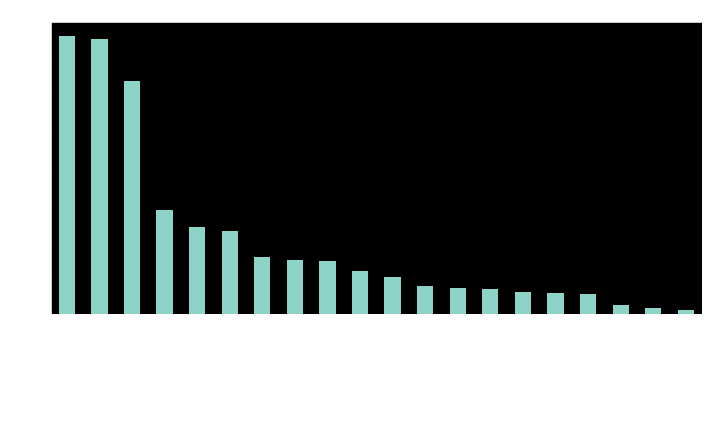

CatBoost 模型已保存到 ../result/model/


In [36]:
# CatBoost 训练与预测示例
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib
import matplotlib.pyplot as plt

# 准备数据（与 XGBoost/LightGBM 一致）
# X_scaled, y_scaled 需要在之前单元中已经定义并可用
y_for_cat = y_scaled.values.ravel() if hasattr(y_scaled, 'values') else np.array(y_scaled).ravel()

X_train_c, X_temp_c, y_train_c, y_temp_c = train_test_split(X_scaled, y_for_cat, test_size=0.2, random_state=42)
X_val_c, X_test_c, y_val_c, y_test_c = train_test_split(X_temp_c, y_temp_c, test_size=0.5, random_state=42)

print(f'CatBoost 训练集: {X_train_c.shape}, 验证集: {X_val_c.shape}, 测试集: {X_test_c.shape}')

# 将验证集作为 Pool（若存在类别特征，可通过 cat_features 参数传入）
train_pool = Pool(X_train_c, label=y_train_c)
val_pool = Pool(X_val_c, label=y_val_c)

# CatBoost 参数（可调整）
cat_params = {
    'iterations': 2000,
    'learning_rate': 0.05,
    'depth': 8,
    'loss_function': 'RMSE',
    'random_seed': 42,
    'early_stopping_rounds': 50,
    'verbose': 50
}

model_cat = CatBoostRegressor(**cat_params)
# 训练，使用验证集做早停
model_cat.fit(train_pool, eval_set=val_pool, use_best_model=True)

# 在测试集上预测
y_pred_cat_scaled = model_cat.predict(X_test_c)

# 反标准化（使用 scaler_y）
try:
    y_test_cat_orig = scaler_y.inverse_transform(y_test_c.reshape(-1,1))
    y_pred_cat_orig = scaler_y.inverse_transform(y_pred_cat_scaled.reshape(-1,1))
except Exception as e:
    print('反标准化失败，返回标准化数据，错误:', e)
    y_test_cat_orig = y_test_c.reshape(-1,1)
    y_pred_cat_orig = y_pred_cat_scaled.reshape(-1,1)

# 评估指标（反标准化后的）
mse_cat = mean_squared_error(y_test_cat_orig, y_pred_cat_orig)
rmse_cat = np.sqrt(mse_cat)
mae_cat = mean_absolute_error(y_test_cat_orig, y_pred_cat_orig)
r2_cat = r2_score(y_test_cat_orig, y_pred_cat_orig)

# 计算 SMAPE
def calculate_smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true).ravel(), np.array(y_pred).ravel()
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denominator = np.where(denominator == 0, 1e-8, denominator)
    return 100 * np.mean(np.abs(y_pred - y_true) / denominator)

smape_cat = calculate_smape(y_test_cat_orig, y_pred_cat_orig)

print(f'CatBoost MSE: {mse_cat:.4f}')
print(f'RMSE: {rmse_cat:.4f}')
print(f'MAE: {mae_cat:.4f}')
print(f'R2: {r2_cat:.4f}')
print(f'SMAPE: {smape_cat:.4f}%')

# 特征重要性
try:
    # 获取数值型特征重要性并用 pandas/matplotlib 绘图（兼容不同 catboost 版本）
    import pandas as pd
    import matplotlib.pyplot as plt
    importances = model_cat.get_feature_importance()
    # 尝试使用训练数据的列名作为特征名，否则使用索引名
    try:
        feature_names = X_train_c.columns
    except Exception:
        feature_names = [f'feature_{i}' for i in range(len(importances))]
    fi_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    print(fi_series.head(20))
    # 绘制前20个特征重要性
    ax = fi_series.head(20).plot(kind='bar', figsize=(10,6))
    ax.set_title('CatBoost Feature Importance')
    ax.set_ylabel('Importance')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('绘制或获取特征重要性失败:', e)

# 保存模型
model_cat.save_model('../result/model/catboost_model.cbm')
joblib.dump(model_cat, '../result/model/catboost_model_joblib.pkl')
print('CatBoost 模型已保存到 ../result/model/')

## 使用 LightGBM 训练与预测

In [ ]:
# LightGBM 训练与预测示例
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib

# 使用已准备好的 X_scaled 和 y_scaled（与 XGBoost 部分保持一致）
# 如果 y_scaled 是 DataFrame，取其列为一维数组
y_for_lgb = y_scaled.values.ravel() if hasattr(y_scaled, 'values') else np.array(y_scaled).ravel()

# 划分数据集（小样本或调试时可减小 num_boost_round）
X_train_l, X_temp_l, y_train_l, y_temp_l = train_test_split(X_scaled, y_for_lgb, test_size=0.2, random_state=42)
X_val_l, X_test_l, y_val_l, y_test_l = train_test_split(X_temp_l, y_temp_l, test_size=0.5, random_state=42)

print(f'LightGBM 训练集: {X_train_l.shape}, 验证集: {X_val_l.shape}, 测试集: {X_test_l.shape}')

# 创建 Dataset 对象
dtrain_l = lgb.Dataset(X_train_l, label=y_train_l)
dval_l = lgb.Dataset(X_val_l, label=y_val_l, reference=dtrain_l)

# LightGBM 参数（可根据需要调整）
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.1,
    'num_leaves': 256,         
    'feature_fraction': 1.0,    
    'bagging_fraction': 0.8,     
    'bagging_freq': 5,           
    'lambda_l1': 1,              
    'lambda_l2': 1,              
    'verbose': -1
}

# 训练模型，使用 callbacks 实现 early stopping 和日志打印（兼容不同 lightgbm 版本）
num_round = 16000
# callbacks 替代早停与 verbose 参数，避免版本差异导致的错误
callbacks = [lgb.early_stopping(20), lgb.log_evaluation(20)]
model_lgb = lgb.train(
    lgb_params,
    dtrain_l,
    num_boost_round=num_round,
    valid_sets=[dtrain_l, dval_l],
    valid_names=['train','valid'],
    callbacks=callbacks
)

# 在测试集上预测（选用最佳迭代次数，如果存在）
best_iter = getattr(model_lgb, 'best_iteration', None) or num_round
y_pred_l = model_lgb.predict(X_test_l, num_iteration=best_iter)

# 反标准化（使用之前保存的 scaler_y）
try:
    y_test_orig_l = scaler_y.inverse_transform(y_test_l.reshape(-1,1))
    y_pred_orig_l = scaler_y.inverse_transform(y_pred_l.reshape(-1,1))
except Exception as e:
    # 如果 scaler_y 不存在或形状不匹配，保留原始标准化结果
    print('反标准化失败，返回标准化结果，错误:', e)
    y_test_orig_l = y_test_l.reshape(-1,1)
    y_pred_orig_l = y_pred_l.reshape(-1,1)

def calculate_smape(y_true, y_pred):
    """
    计算 Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    y_true, y_pred = np.array(y_true).ravel(), np.array(y_pred).ravel()
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true)
    
    # 避免除以零，将分母中为零的项替换为一个小值
    denominator = np.where(denominator == 0, 1e-8, denominator)
    
    smape = 100 * np.mean(diff / denominator)
    return smape

# 评估指标（反归一化后的）
mse_l = mean_squared_error(y_test_orig_l, y_pred_orig_l)
rmse_l = np.sqrt(mse_l)
mae_l = mean_absolute_error(y_test_orig_l, y_pred_orig_l)
r2_l = r2_score(y_test_orig_l, y_pred_orig_l)
smape_l = calculate_smape(y_test_orig_l, y_pred_orig_l)

print(f'LightGBM MSE: {mse_l:.4f}')
print(f'RMSE: {rmse_l:.4f}')
print(f'MAE: {mae_l:.4f}')
print(f'R2: {r2_l:.4f}')
print(f'smape: {smape_l:.4f}%')

LightGBM 训练集: (1648058, 34), 验证集: (206007, 34), 测试集: (206008, 34)
Training until validation scores don't improve for 20 rounds
Training until validation scores don't improve for 20 rounds
[20]	train's rmse: 0.455053	valid's rmse: 0.455112
[20]	train's rmse: 0.455053	valid's rmse: 0.455112
[40]	train's rmse: 0.416095	valid's rmse: 0.416552
[40]	train's rmse: 0.416095	valid's rmse: 0.416552
[60]	train's rmse: 0.402386	valid's rmse: 0.403659
[60]	train's rmse: 0.402386	valid's rmse: 0.403659
[80]	train's rmse: 0.393656	valid's rmse: 0.395633
[80]	train's rmse: 0.393656	valid's rmse: 0.395633
[100]	train's rmse: 0.387366	valid's rmse: 0.390235
[100]	train's rmse: 0.387366	valid's rmse: 0.390235
[120]	train's rmse: 0.381971	valid's rmse: 0.385592
[120]	train's rmse: 0.381971	valid's rmse: 0.385592
[140]	train's rmse: 0.377547	valid's rmse: 0.38198
[140]	train's rmse: 0.377547	valid's rmse: 0.38198
[160]	train's rmse: 0.373552	valid's rmse: 0.378709
[160]	train's rmse: 0.373552	valid's rmse:

In [ ]:
# 展示前20条真实 vs 预测（反标准化后）
for i, (t, p) in enumerate(zip(y_test_orig_l[:20], y_pred_orig_l[:20])):
    t_val = t.item() if hasattr(t, 'item') else float(t)
    p_val = p.item() if hasattr(p, 'item') else float(p)
    print(f'第{i+1}条: 真实={t_val}, 预测={p_val:.2f}')

第1条: 真实=23.0, 预测=29.79
第2条: 真实=49.0, 预测=33.64
第3条: 真实=60.0, 预测=89.42
第4条: 真实=52.99999999999999, 预测=62.30
第5条: 真实=121.0, 预测=137.69
第6条: 真实=148.0, 预测=141.24
第7条: 真实=111.0, 预测=130.78
第8条: 真实=92.0, 预测=102.05
第9条: 真实=159.0, 预测=153.00
第10条: 真实=128.0, 预测=125.27
第11条: 真实=169.0, 预测=156.73
第12条: 真实=22.0, 预测=19.05
第13条: 真实=137.0, 预测=129.57
第14条: 真实=58.0, 预测=51.08
第15条: 真实=133.0, 预测=154.47
第16条: 真实=43.0, 预测=34.46
第17条: 真实=100.0, 预测=93.73
第18条: 真实=98.0, 预测=125.29
第19条: 真实=146.0, 预测=142.21
第20条: 真实=175.0, 预测=175.07


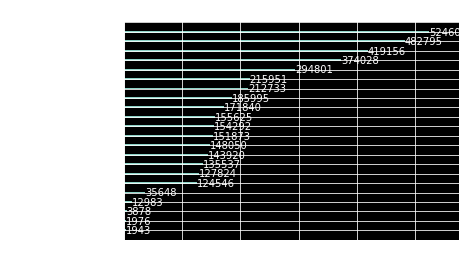

LightGBM 模型已保存到 ../result/model/


In [ ]:
# 特征重要性可视化
import matplotlib.pyplot as plt
lgb.plot_importance(model_lgb, max_num_features=30)
plt.show()

# 保存 LightGBM 模型和可重复使用的 artifacts
model_lgb.save_model('../result/model/lightgbm_model.txt')
joblib.dump(model_lgb, '../result/model/lightgbm_model_joblib.pkl')
print('LightGBM 模型已保存到 ../result/model/')

In [16]:
# Stacking 融合：使用 MLPRegressor 将 XGBoost/LightGBM/CatBoost 的预测作为元特征训练一个神经网络集成模型
import numpy as np
import pandas as pd
import joblib
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 确保基础模型存在；若在当前命名空间中找不到，则从磁盘加载（尝试常见保存路径）
try:
    has_xgb = 'model' in globals()
    has_lgb = 'model_lgb' in globals()
    has_cat = 'model_cat' in globals()
except Exception:
    has_xgb = has_lgb = has_cat = False

# 尝试从磁盘加载缺失的模型（非破坏性）
if not has_xgb:
    try:
        import xgboost as xgb
        m_xgb = xgb.Booster()
        m_xgb.load_model('../result/model/guiyihua_xgboost_model_1000.json')
        model = m_xgb
        has_xgb = True
    except Exception as e:
        print('未能在内存或磁盘加载 XGBoost 模型（将跳过或报错）:', e)

if not has_lgb:
    try:
        import lightgbm as lgb
        model_lgb = lgb.Booster(model_file='../result/model/lightgbm_model.txt')
        has_lgb = True
    except Exception as e:
        try:
            model_lgb = joblib.load('../result/model/lightgbm_model_joblib.pkl')
            has_lgb = True
        except Exception as e2:
            print('未能在内存或磁盘加载 LightGBM 模型（将跳过或报错）:', e, e2)

if not has_cat:
    try:
        from catboost import CatBoostRegressor
        model_cat = CatBoostRegressor()
        model_cat.load_model('../result/model/catboost_model.cbm')
        has_cat = True
    except Exception as e:
        try:
            model_cat = joblib.load('../result/model/catboost_model_joblib.pkl')
            has_cat = True
        except Exception as e2:
            print('未能在内存或磁盘加载 CatBoost 模型（将跳过或报错）:', e, e2)

# 检查是否至少有三个基础模型可用（为公平起见，建议三者都存在）
if not (has_xgb and has_lgb and has_cat):
    print('警告：并非所有基础模型都可用。确保已成功训练并保存三个基础模型以获得最佳融合效果。')

# 准备训练/测试集（使用前面 X_train/X_test, y_train/y_test），如果不存在则尝试用其它变量回退
if 'X_train' in globals() and 'X_test' in globals() and 'y_train' in globals() and 'y_test' in globals():
    X_tr = X_train
    X_te = X_test
    y_tr = y_train
    y_te = y_test
else:
    raise RuntimeError('找不到 X_train/X_test/y_train/y_test，请先运行 XGBoost 的数据划分单元以生成训练/测试集。')

# 对每个基础模型在训练集与测试集上生成预测（输出为原始尺度）
def pred_xgb(m, X):
    try:
        import xgboost as xgb
        d = xgb.DMatrix(X)
        out = m.predict(d)
    except Exception:
        # 当 model 是 sklearn wrapper 或其它实现时，尝试直接传入 X
        out = m.predict(X)
    return out

def pred_lgb(m, X):
    try:
        best = getattr(m, 'best_iteration', None) or -1
        return m.predict(X, num_iteration=best)
    except Exception:
        return m.predict(X)

def pred_cat(m, X):
    try:
        return m.predict(X)
    except Exception:
        # 如果需要 Pool，请尝试
        from catboost import Pool
        return m.predict(Pool(X))

# 训练集预测（可能是标准化后的值）
p_xgb_tr = pred_xgb(model, X_tr) if has_xgb else np.zeros(len(X_tr))
p_lgb_tr = pred_lgb(model_lgb, X_tr) if has_lgb else np.zeros(len(X_tr))
p_cat_tr = pred_cat(model_cat, X_tr) if has_cat else np.zeros(len(X_tr))

p_xgb_te = pred_xgb(model, X_te) if has_xgb else np.zeros(len(X_te))
p_lgb_te = pred_lgb(model_lgb, X_te) if has_lgb else np.zeros(len(X_te))
p_cat_te = pred_cat(model_cat, X_te) if has_cat else np.zeros(len(X_te))

# 反标准化预测值（尝试使用 scaler_y；若失败则保留原始）
try:
    p_xgb_tr_o = scaler_y.inverse_transform(np.array(p_xgb_tr).reshape(-1,1)).ravel()
    p_lgb_tr_o = scaler_y.inverse_transform(np.array(p_lgb_tr).reshape(-1,1)).ravel()
    p_cat_tr_o = scaler_y.inverse_transform(np.array(p_cat_tr).reshape(-1,1)).ravel()
    p_xgb_te_o = scaler_y.inverse_transform(np.array(p_xgb_te).reshape(-1,1)).ravel()
    p_lgb_te_o = scaler_y.inverse_transform(np.array(p_lgb_te).reshape(-1,1)).ravel()
    p_cat_te_o = scaler_y.inverse_transform(np.array(p_cat_te).reshape(-1,1)).ravel()
    y_tr_o = scaler_y.inverse_transform(np.array(y_tr).reshape(-1,1)).ravel()
    y_te_o = scaler_y.inverse_transform(np.array(y_te).reshape(-1,1)).ravel()
except Exception as e:
    print('反标准化失败，使用原始预测尺度（可能为已标准化）。错误:', e)
    p_xgb_tr_o = np.array(p_xgb_tr).ravel(); p_lgb_tr_o = np.array(p_lgb_tr).ravel(); p_cat_tr_o = np.array(p_cat_tr).ravel()
    p_xgb_te_o = np.array(p_xgb_te).ravel(); p_lgb_te_o = np.array(p_lgb_te).ravel(); p_cat_te_o = np.array(p_cat_te).ravel()
    y_tr_o = np.array(y_tr).ravel(); y_te_o = np.array(y_te).ravel()

# 组装元特征并训练 MLP 融合器
X_meta_tr = np.column_stack([p_xgb_tr_o, p_lgb_tr_o, p_cat_tr_o])
X_meta_te = np.column_stack([p_xgb_te_o, p_lgb_te_o, p_cat_te_o])

print('元特征形状: train', X_meta_tr.shape, 'test', X_meta_te.shape)

mlp = MLPRegressor(hidden_layer_sizes=(32,16), activation='relu', solver='adam', random_state=42, max_iter=1000)
mlp.fit(X_meta_tr, y_tr_o)

# 在测试集上评估融合模型
y_pred_meta = mlp.predict(X_meta_te)
mse_s = mean_squared_error(y_te_o, y_pred_meta)
mae_s = mean_absolute_error(y_te_o, y_pred_meta)
rmse_s = np.sqrt(mse_s)
def calc_mape(a,b):
    a,b = np.array(a).ravel(), np.array(b).ravel(); a = np.where(a==0,1e-8,a); return 100*np.mean(np.abs((a-b)/a))
def calc_smape(a,b):
    a,b = np.array(a).ravel(), np.array(b).ravel(); denom = (np.abs(a)+np.abs(b))/2.0; denom = np.where(denom==0,1e-8,denom); return 100*np.mean(np.abs(b-a)/denom)
mape_s = calc_mape(y_te_o, y_pred_meta)
smape_s = calc_smape(y_te_o, y_pred_meta)
r2_s = r2_score(y_te_o, y_pred_meta)

print(f'Stacking MLP 评估: MSE={mse_s:.4f}, RMSE={rmse_s:.4f}, MAE={mae_s:.4f}, MAPE={mape_s:.4f}%, SMAPE={smape_s:.4f}%, R2={r2_s:.4f}')

# 比较基模型在相同测试集的表现
print('基模型在相同测试集的表现（原始尺度）:')
for name, pred in [('XGBoost', p_xgb_te_o), ('LightGBM', p_lgb_te_o), ('CatBoost', p_cat_te_o)]:
    mse_b = mean_squared_error(y_te_o, pred)
    rmse_b = np.sqrt(mse_b)
    mae_b = mean_absolute_error(y_te_o, pred)
    mape_b = calc_mape(y_te_o, pred)
    smape_b = calc_smape(y_te_o, pred)
    r2_b = r2_score(y_te_o, pred)
    print(f'{name}: MSE={mse_b:.4f}, RMSE={rmse_b:.4f}, MAE={mae_b:.4f}, MAPE={mape_b:.4f}%, SMAPE={smape_b:.4f}%, R2={r2_b:.4f}')

# 在全量数据上生成融合预测并保存（尝试使用 X_scaled 生成基模型预测）
try:
    p_xgb_all = pred_xgb(model, X_scaled) if has_xgb else np.zeros(len(X_scaled))
    p_lgb_all = pred_lgb(model_lgb, X_scaled) if has_lgb else np.zeros(len(X_scaled))
    p_cat_all = pred_cat(model_cat, X_scaled) if has_cat else np.zeros(len(X_scaled))
    try:
        p_xgb_all_o = scaler_y.inverse_transform(np.array(p_xgb_all).reshape(-1,1)).ravel()
        p_lgb_all_o = scaler_y.inverse_transform(np.array(p_lgb_all).reshape(-1,1)).ravel()
        p_cat_all_o = scaler_y.inverse_transform(np.array(p_cat_all).reshape(-1,1)).ravel()
    except Exception:
        p_xgb_all_o = np.array(p_xgb_all).ravel(); p_lgb_all_o = np.array(p_lgb_all).ravel(); p_cat_all_o = np.array(p_cat_all).ravel()
    X_meta_all = np.column_stack([p_xgb_all_o, p_lgb_all_o, p_cat_all_o])
    predictions_stack = mlp.predict(X_meta_all)
    joblib.dump(mlp, '../result/model/stacking_nn_joblib.pkl')
    pd.DataFrame({'pred_stack': predictions_stack}).to_csv('../result/model/predictions_stack.csv', index=False)
    print('已保存融合模型与全量融合预测到 ../result/model/')
except Exception as e:
    print('无法在全量数据上生成融合预测:', e)


c:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


RuntimeError: 找不到 X_train/X_test/y_train/y_test，请先运行 XGBoost 的数据划分单元以生成训练/测试集。

## 超参数设置

## 不同特征重要程度测试

## xgboost


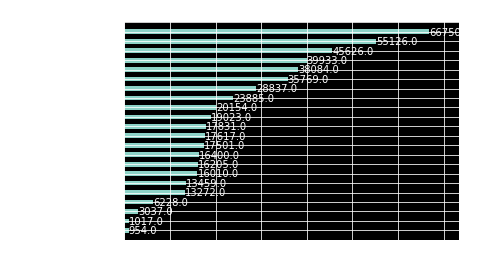

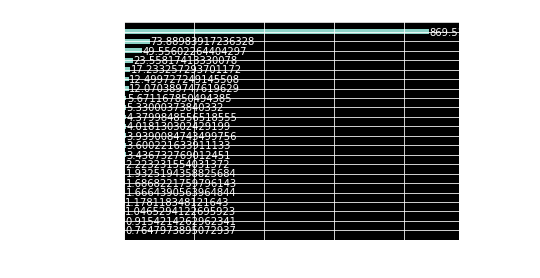

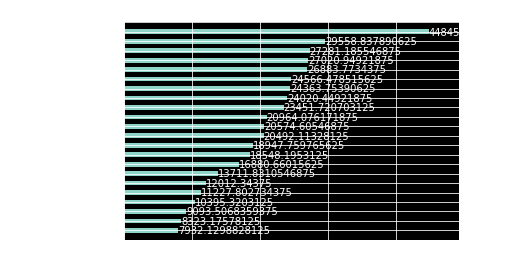

In [20]:
import xgboost as xgb
import matplotlib.pyplot as plt

# 假设 model 是训练好的 XGBoost 模型
xgb.plot_importance(model, importance_type='weight', title="Feature Importance (Weight)", height=0.5)
plt.show()

xgb.plot_importance(model, importance_type='gain', title="Feature Importance (Gain)", height=0.5)
plt.show()

xgb.plot_importance(model, importance_type='cover', title="Feature Importance (Cover)", height=0.5)
plt.show()